In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_2')

In [3]:
datasets_order = {
    'chains_eq_2': 0,
    'chains_eq_3': 1,
    'chains_ge_4_lt_10': 2,
    'chains_ge_10': 3}

datasets_dict = {
    'chains_eq_2': r'Chain length $= 2$',
    'chains_eq_3': r'Chain length $= 3$',
    'chains_ge_4_lt_10': r'Chain 10 $>$ length $\geq$ 4',
    'chains_ge_10': r'Chain length $\geq$ 10'}

In [4]:
sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size

In [5]:
df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)

In [6]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_kmeans.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy, - Better']
# ncols = len(scores)
# nrows = len(datasets)
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

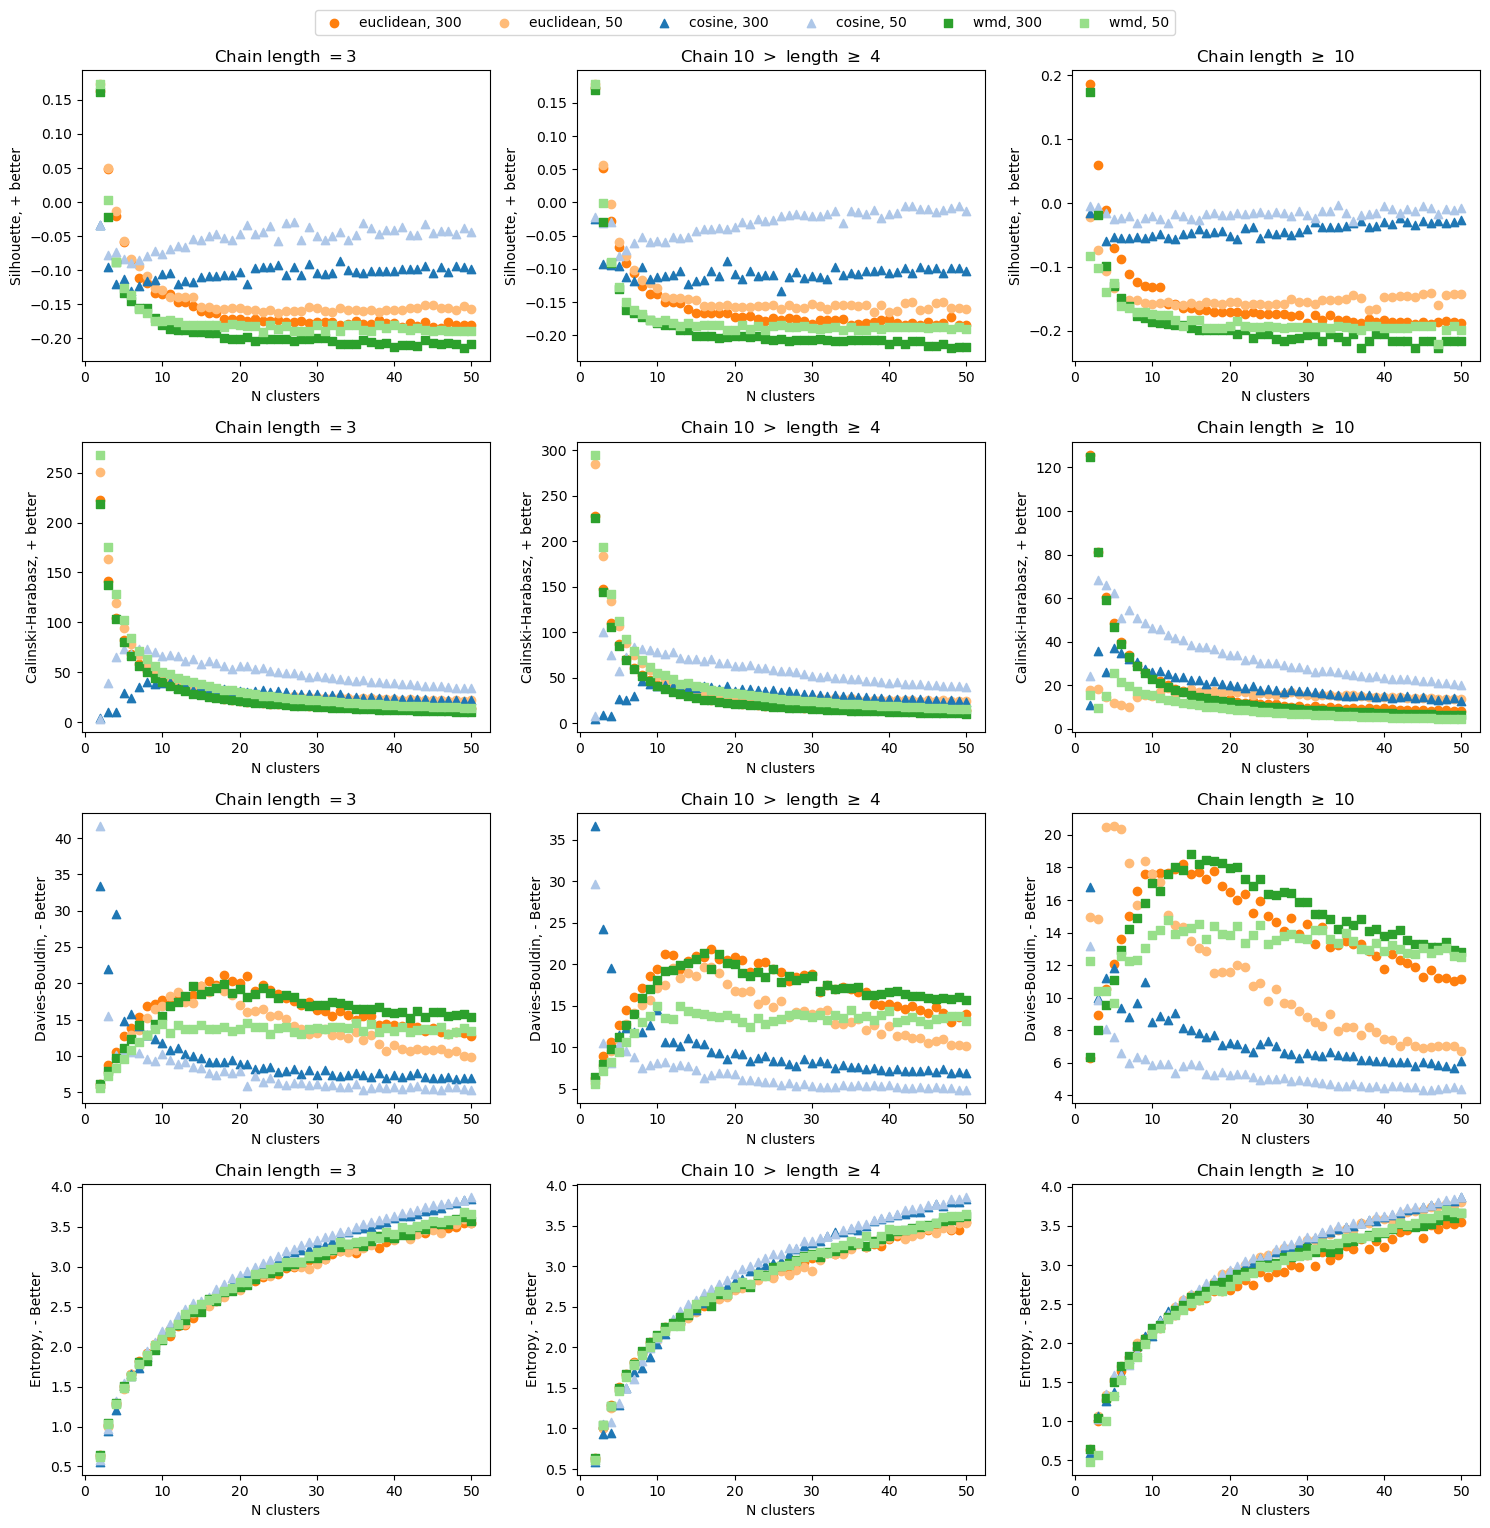

In [7]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_kmeans.loc[df_kmeans['dataset']==datasets[col],:].sort_values('n_clusters')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2])
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^')
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s')
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s')
        axes[row][col].set_title(fr'{datasets_dict[datasets[col]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[row])
        handles, labels = axes[row][col].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
fig.savefig(Path('../img/scores_km.png'), bbox_inches='tight')
plt.show()

In [8]:
df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)

In [9]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
# ncols = len(scores)
# nrows = len(datasets)
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

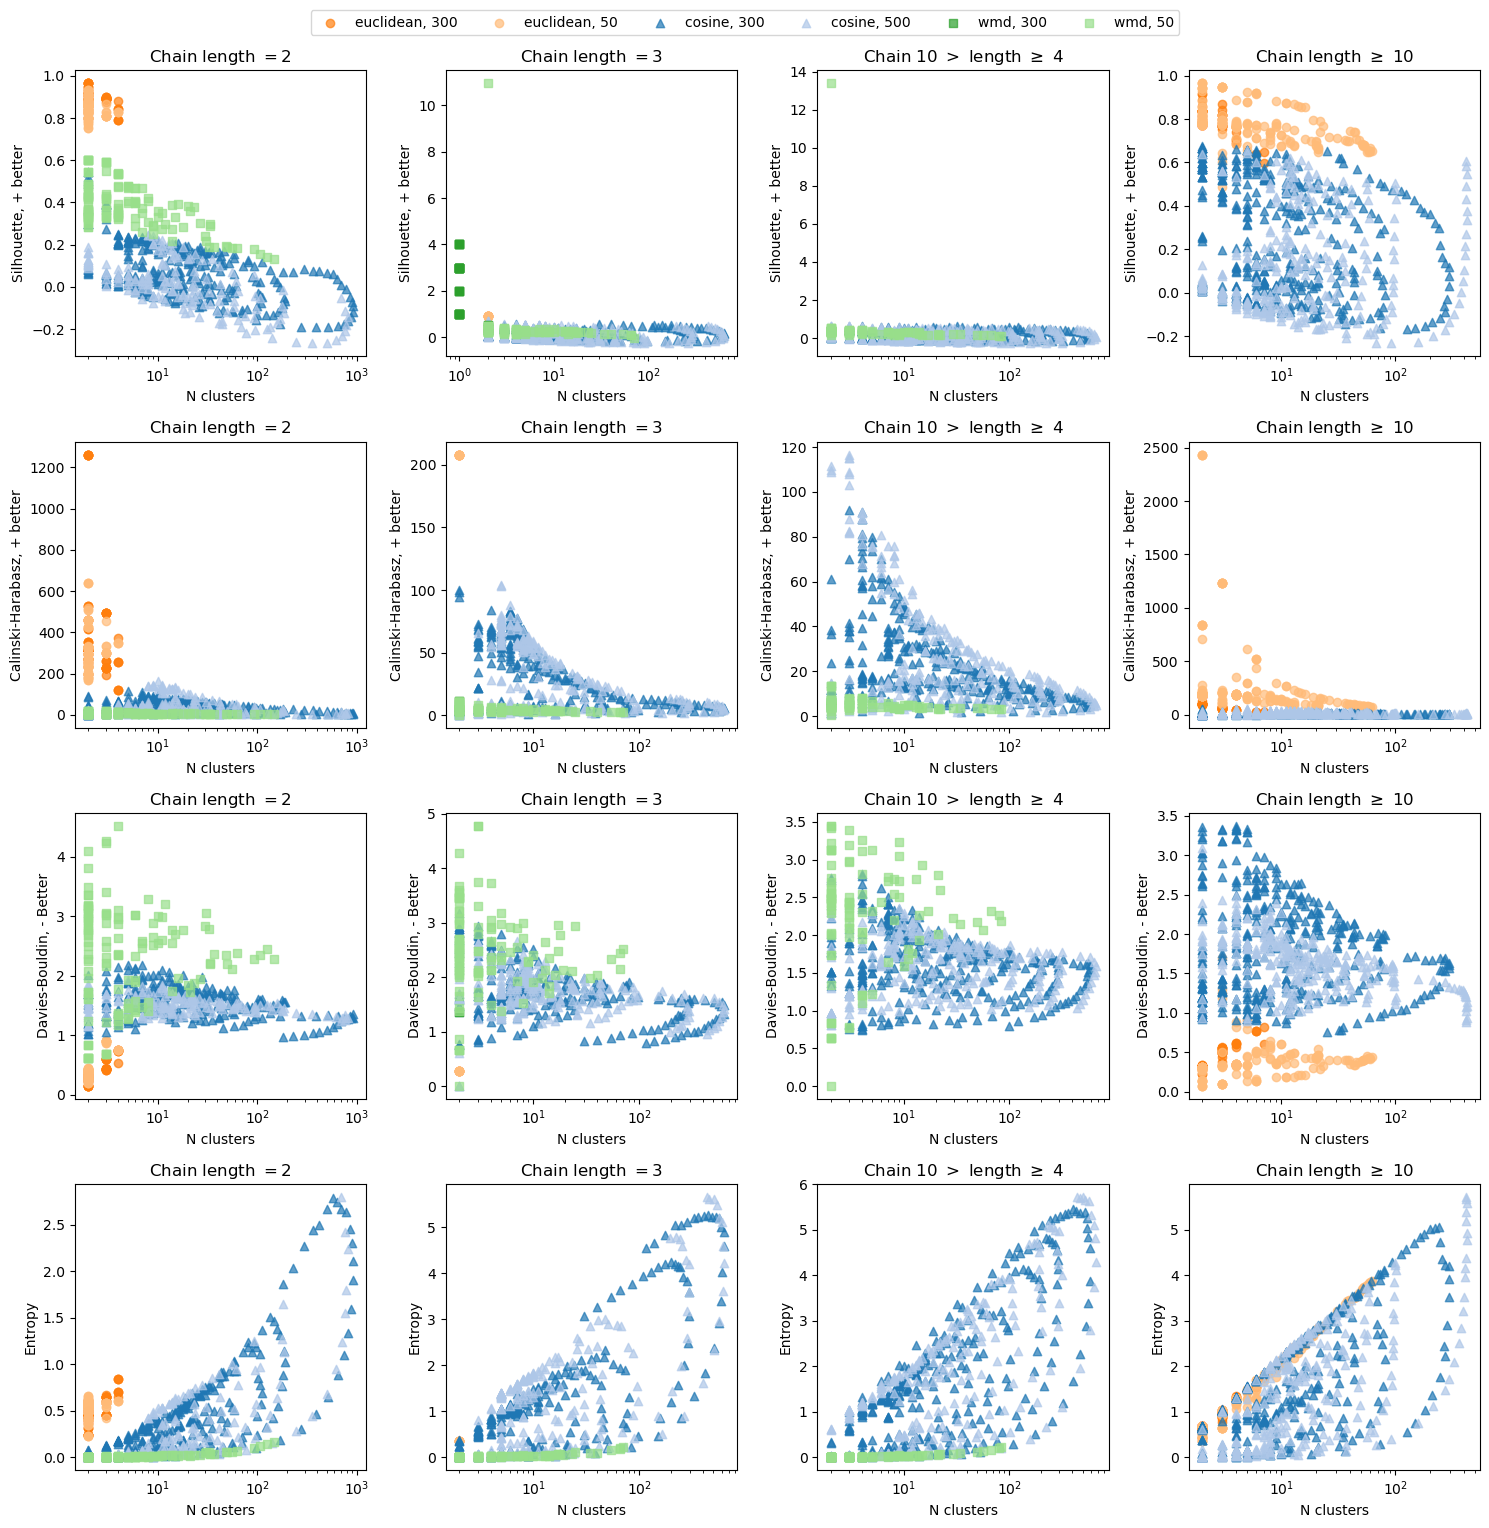

In [10]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.loc[df_dbscan['dataset']==datasets[col],:].sort_values('n_clusters')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 500', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_dict[datasets[col]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[row])
        axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
fig.savefig(Path('../img/scores_dbscan.png'), bbox_inches='tight')
plt.show()

In [12]:
hdbscan_list = [pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')]
df_hdbscan = pd.concat(hdbscan_list, ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)

In [13]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_hdbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
# ncols = len(scores)
# nrows = len(datasets)
ncols = len(datasets)
nrows = len(scores)

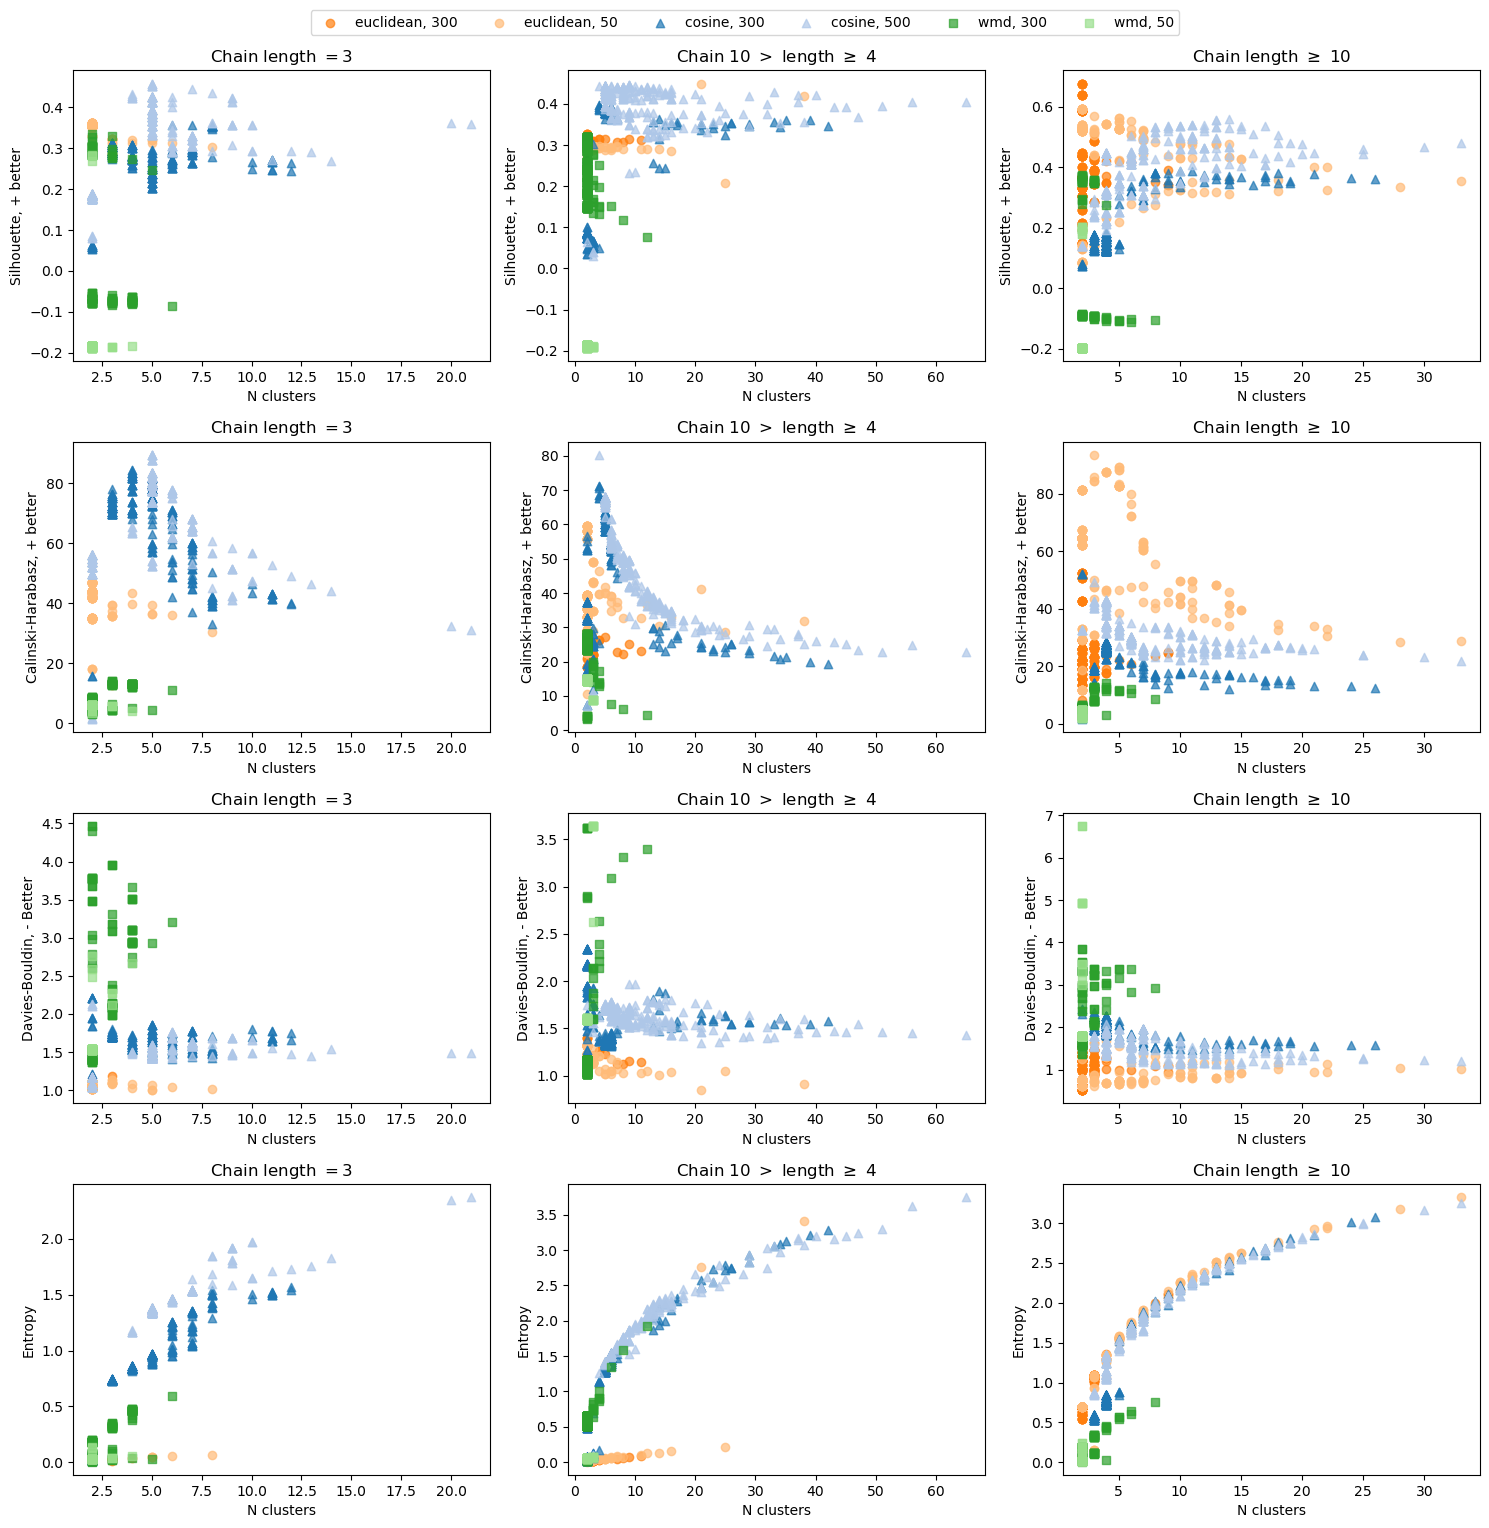

In [14]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_hdbscan.loc[df_hdbscan['dataset']==datasets[col],:].sort_values('n_clusters')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 500', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_dict[datasets[col]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[row])
        # axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
fig.savefig(Path('../img/scores_hdbscan.png'), bbox_inches='tight')
plt.show()

In [15]:
df_kmeans = df_kmeans.sort_values('order')
df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
df_kmeans['method'] = 'KMeans'
df_dbscan = df_dbscan.sort_values('order')
df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_dbscan['method'] = 'DBSCAN'
df_hdbscan = df_hdbscan.sort_values('order')
df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_hdbscan['method'] = 'HDBSCAN'
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()

In [22]:
columns = ['order', 'dataset', 'dimensions', 'method', 'k_noise', 'sl_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_sl = pd.concat(scores)
df_sl.pivot(index=columns[:3], columns=columns[3]).droplevel(0)

k_noise                      sl_score  \
method                            DBSCAN     HDBSCAN KMeans     DBSCAN   
dataset           dimensions                                             
chains_eq_2       300          2 (0.999)         NaN    NaN   0.964181   
                  50           2 (0.999)         NaN    NaN   0.931949   
chains_eq_3       300            1 (nan)   6 (0.962)      2   4.000000   
                  50           2 (0.000)   5 (0.971)      2  10.954556   
chains_ge_4_lt_10 300         32 (0.986)   4 (0.974)      2   0.617345   
                  50           2 (0.000)  21 (0.978)      2  13.392527   
chains_ge_10      300          2 (0.998)   2 (0.996)      2   0.916731   
                  50           2 (0.997)   2 (0.992)     34   0.964790   

                                                  
method                         HDBSCAN    KMeans  
dataset           dimensions                      
chains_eq_2       300              NaN       NaN  
                  50               NaN       NaN  
chains_eq_3       300         0.357546  0.162625  
                  50          0.458011  0.173849  
chains_ge_4_lt_10 300         0.397475  0.171795  
                  50          0.449560  0.179216  
chains_ge_10      300         0.676392  0.187294  
                  50          0.591577 -0.003003

In [23]:
columns = ['order', 'dataset','dimensions', 'method', 'k_noise', 'ch_score'] # n_clusters
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_ch = pd.concat(scores)
df_ch.pivot(index=columns[:3], columns=columns[3]).droplevel(0)

k_noise                       ch_score  \
method                           DBSCAN    HDBSCAN KMeans       DBSCAN   
dataset           dimensions                                             
chains_eq_2       300         2 (0.999)        NaN    NaN  1262.370956   
                  50          2 (0.999)        NaN    NaN   639.064924   
chains_eq_3       300         2 (0.991)  4 (0.926)      2   100.261447   
                  50          2 (0.998)  5 (0.937)      2   207.982802   
chains_ge_4_lt_10 300         3 (0.991)  4 (0.973)      2    91.897215   
                  50          3 (0.972)  4 (0.970)      2   116.628079   
chains_ge_10      300         2 (0.998)  2 (0.995)      2   200.884961   
                  50          2 (0.997)  3 (0.989)      3  2433.836355   

                                                     
method                          HDBSCAN      KMeans  
dataset           dimensions                         
chains_eq_2       300               NaN         NaN  
                  50                NaN         NaN  
chains_eq_3       300         84.432433  222.919579  
                  50          89.413745  267.857486  
chains_ge_4_lt_10 300         71.046495  228.337123  
                  50          80.243483  295.161064  
chains_ge_10      300         52.483059  125.792456  
                  50          93.603424   68.321102

In [24]:
columns = ['order', 'dataset', 'dimensions', 'method', 'k_noise', 'db_score'] # n_clusters
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_db = pd.concat(scores)
df_db.pivot(index=columns[:3], columns=columns[3]).droplevel(0)

k_noise                     db_score  \
method                           DBSCAN     HDBSCAN KMeans    DBSCAN   
dataset           dimensions                                           
chains_eq_2       300         2 (0.999)         NaN    NaN  0.150688   
                  50          2 (0.999)         NaN    NaN  0.194879   
chains_eq_3       300         2 (0.991)   3 (0.154)      2  0.761152   
                  50          2 (0.000)   5 (0.284)     46  0.002141   
chains_ge_4_lt_10 300         4 (0.997)   2 (0.989)      2  0.745530   
                  50          2 (0.000)  21 (0.978)     49  0.001960   
chains_ge_10      300         2 (0.998)   2 (0.996)     49  0.227793   
                  50          2 (0.997)   3 (0.989)     45  0.076238   

                                                  
method                         HDBSCAN    KMeans  
dataset           dimensions                      
chains_eq_2       300              NaN       NaN  
                  50               NaN       NaN  
chains_eq_3       300         1.182062  6.117431  
                  50          0.997430  5.260462  
chains_ge_4_lt_10 300         1.014315  6.348298  
                  50          0.844244  4.835476  
chains_ge_10      300         0.517278  5.704516  
                  50          0.613239  4.309654

In [25]:
columns = ['order', 'dataset', 'dimensions', 'method', 'k_noise', 'entropy']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_en = pd.concat(scores)
df_en.pivot(index=columns[:3], columns=columns[3]).droplevel(0)

k_noise                     entropy            \
method                           DBSCAN    HDBSCAN KMeans    DBSCAN   HDBSCAN   
dataset           dimensions                                                    
chains_eq_2       300         2 (0.001)        NaN    NaN  0.000872       NaN   
                  50          2 (0.000)        NaN    NaN  0.000872       NaN   
chains_eq_3       300         2 (0.020)  2 (0.117)      2  0.002180  0.006325   
                  50          2 (0.189)  2 (0.159)      2  0.001387  0.007554   
chains_ge_4_lt_10 300         2 (0.011)  2 (0.376)      2  0.001980  0.006709   
                  50          2 (0.000)  2 (0.319)      2  0.001961  0.006212   
chains_ge_10      300         2 (0.014)  2 (0.258)      2  0.003381  0.009711   
                  50          2 (0.005)  2 (0.121)      2  0.003354  0.016569   

                                        
method                          KMeans  
dataset           dimensions            
chains_eq_2       300              NaN  
                  50               NaN  
chains_eq_3       300         0.561802  
                  50          0.580560  
chains_ge_4_lt_10 300         0.592926  
                  50          0.614685  
chains_ge_10      300         0.594943  
                  50          0.483883

In [26]:
print(
    df_sl.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3" halign="left">k_noise</th>
      <th colspan="3" halign="left">sl_score</th>
    </tr>
    <tr>
      <th></th>
      <th>method</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
    </tr>
    <tr>
      <th>dataset</th>
      <th>dimensions</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="2" valign="top">chains_eq_2</th>
      <th>300</th>
      <td>2 (0.999)</td>
      <td>-</td>
      <td>-</td>
      <td>0.964</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th>50</th>
      <td>2 (0.999)</td>
      <td>-</td>
      <td>-</td>
      <td>0.932</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">chains_eq_3</th>
      <th>3

In [27]:
print(
    df_ch.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)
# print(
#     df_ch.pivot_table(
#         index=['dataset', 'dimensions'], columns=['method'], values=['n_clusters','ch_score'],fill_value=0
#     ).to_html(na_rep='-', float_format="%.3f")
# )

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3" halign="left">k_noise</th>
      <th colspan="3" halign="left">ch_score</th>
    </tr>
    <tr>
      <th></th>
      <th>method</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
    </tr>
    <tr>
      <th>dataset</th>
      <th>dimensions</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="2" valign="top">chains_eq_2</th>
      <th>300</th>
      <td>2 (0.999)</td>
      <td>-</td>
      <td>-</td>
      <td>1262.371</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th>50</th>
      <td>2 (0.999)</td>
      <td>-</td>
      <td>-</td>
      <td>639.065</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">chains_eq_3</th>
      

In [28]:
print(
    df_db.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)
# print(
#     df_db.pivot_table(
#         index=['dataset', 'dimensions'], columns=['method'], values=['n_clusters','db_score'],fill_value=0
#     ).to_html(na_rep='-', float_format="%.3f")
# )

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3" halign="left">k_noise</th>
      <th colspan="3" halign="left">db_score</th>
    </tr>
    <tr>
      <th></th>
      <th>method</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
    </tr>
    <tr>
      <th>dataset</th>
      <th>dimensions</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="2" valign="top">chains_eq_2</th>
      <th>300</th>
      <td>2 (0.999)</td>
      <td>-</td>
      <td>-</td>
      <td>0.151</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th>50</th>
      <td>2 (0.999)</td>
      <td>-</td>
      <td>-</td>
      <td>0.195</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">chains_eq_3</th>
      <th>3

In [29]:
print(
    df_en.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)
# print(
#     df_en.pivot_table(
#         index=['dataset', 'dimensions'], columns=['method'], values=['n_clusters','entropy'],fill_value=0
#     ).to_html(na_rep='-', float_format="%.3f")
# )

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3" halign="left">k_noise</th>
      <th colspan="3" halign="left">entropy</th>
    </tr>
    <tr>
      <th></th>
      <th>method</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
    </tr>
    <tr>
      <th>dataset</th>
      <th>dimensions</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="2" valign="top">chains_eq_2</th>
      <th>300</th>
      <td>2 (0.001)</td>
      <td>-</td>
      <td>-</td>
      <td>0.001</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th>50</th>
      <td>2 (0.000)</td>
      <td>-</td>
      <td>-</td>
      <td>0.001</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">chains_eq_3</th>
      <th>30

In [16]:
methods = ['kmeans', 'dbscan', 'hdbscan']
datasets = np.sort(df_dbscan['dataset'].unique())

In [15]:
# X = df_hdbscan.sort_values('n_clusters')
# fig, axes = plt.subplots(nrows, ncols, figsize=(16,20))
# for row in range(nrows):
#     for col in range(ncols):
#         x = X[(X['dataset'] == datasets[row]) & (X['distance']=='cosine')]
#         axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='cosine', alpha=0.3)
#         x = X[(X['dataset'] == datasets[row]) & (X['distance']=='euclidean')]
#         axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='euclidean', alpha=0.3, marker='^')
#         x = X[(X['dataset'] == datasets[row]) & (X['distance']=='wmd')]
#         axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='wmd', alpha=0.3, marker='s')
#         # axes[row][col].legend(title='Distance')
#         axes[row][col].set_title(f'{datasets_dict[datasets[row]]}')
#         axes[row][col].set_xlabel('N clusters')
#         axes[row][col].set_ylabel(score_names[col])
#         handles, labels = axes[row][col].get_legend_handles_labels()

# # fig.tight_layout()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=3) 
# fig.savefig(Path('../img/scores_hdbscan.png'), bbox_inches='tight')
# plt.show()
# print(tab_hdbscan.to_latex(float_format="%.3f", longtable=True, decimal=',', label='tab:hdbscanscores', caption='HDBSCAN Best Scores'))

In [17]:
datasets

array(['chains_eq_2', 'chains_eq_3', 'chains_ge_10', 'chains_ge_4_lt_10'],
      dtype=object)

In [40]:
df_kmeans

,distance,dataset,n_clusters,sl_score,ch_score,db_score,entropy,dimensions,order,k_noise
0,wmd,chains_eq_3,2,0.162067,218.763490,6.171667,0.646228,300,1,1
72,wmd,chains_eq_3,25,-0.185533,25.077422,13.822036,3.001891,50,1,1
23,wmd,chains_eq_3,25,-0.200195,17.675829,17.897747,2.950287,300,1,1
425,cosine,chains_eq_3,35,-0.102121,25.616814,7.676588,3.467241,300,1,1
68,wmd,chains_eq_3,21,-0.181813,29.184737,14.543726,2.811481,50,1,1
...,...,...,...,...,...,...,...,...,...,...
695,cosine,chains_ge_10,11,-0.048629,26.443145,8.864587,2.300249,300,3,1
627,euclidean,chains_ge_10,41,-0.186745,9.119603,12.661588,3.335691,300,3,1
626,euclidean,chains_ge_10,40,-0.182933,9.393179,11.749983,3.225090,300,3,1
854,wmd,chains_ge_10,23,-0.194702,8.098028,13.824338,2.901256,50,3,4


In [41]:
df_kmeans['dataset'].unique()

array(['chains_eq_3', 'chains_ge_4_lt_10', 'chains_ge_10'], dtype=object)

In [22]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns1 = ['order', 'dataset', 'dimensions', 'n_clusters', 'sl_score']
columns2 = ['order', 'dataset', 'dimensions', 'n_clusters', 'prop_noise', 'sl_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns1].sort_values(columns1[-1],ascending=False).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_sl = pd.concat(scores)
df_sl.pivot(index=['dataset', 'dimensions'], columns=['method'])

n_clusters                  sl_score            \
method                           DBSCAN HDBSCAN KMeans     DBSCAN   HDBSCAN   
dataset           dimensions                                                  
chains_eq_2       300               2.0     NaN    NaN   0.964181       NaN   
                  50                2.0     NaN    NaN   0.931949       NaN   
chains_eq_3       300               1.0     6.0    2.0   4.000000  0.357546   
                  50                2.0     5.0    2.0  10.954556  0.458011   
chains_ge_10      300               2.0     2.0    2.0   0.916731  0.676392   
                  50                2.0     2.0   34.0   0.964790  0.591577   
chains_ge_4_lt_10 300              32.0     4.0    2.0   0.617345  0.397475   
                  50                2.0    21.0    2.0  13.392527  0.449560   

                                       prop_noise                   
method                          KMeans     DBSCAN   HDBSCAN KMeans  
dataset           dimensions                                        
chains_eq_2       300              NaN   0.998700       NaN    NaN  
                  50               NaN   0.998574       NaN    NaN  
chains_eq_3       300         0.162625        NaN  0.961569    NaN  
                  50          0.173849   0.000055  0.970806    NaN  
chains_ge_10      300         0.187294   0.997558  0.995868    NaN  
                  50         -0.003003   0.996619  0.991736    NaN  
chains_ge_4_lt_10 300         0.171795   0.986461  0.974370    NaN  
                  50          0.179216   0.000054  0.977883    NaN

In [23]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns1 = ['dataset','dimensions', 'n_clusters', 'ch_score']
columns2 = ['dataset','dimensions', 'n_clusters', 'prop_noise', 'ch_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns1].sort_values(columns1[-1],ascending=False).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_ch = pd.concat(scores)
df_ch.pivot(index=['dataset', 'dimensions'], columns=['method'])

n_clusters                    ch_score  \
method                           DBSCAN HDBSCAN KMeans       DBSCAN   
dataset           dimensions                                          
chains_eq_2       300               2.0     NaN    NaN  1262.370956   
                  50                2.0     NaN    NaN   639.064924   
chains_eq_3       300               2.0     4.0    2.0   100.261447   
                  50                2.0     5.0    2.0   207.982802   
chains_ge_10      300               2.0     2.0    2.0   200.884961   
                  50                2.0     3.0    3.0  2433.836355   
chains_ge_4_lt_10 300               3.0     4.0    2.0    91.897215   
                  50                3.0     4.0    2.0   116.628079   

                                                    prop_noise            \
method                          HDBSCAN      KMeans     DBSCAN   HDBSCAN   
dataset           dimensions                                               
chains_eq_2       300               NaN         NaN   0.998700       NaN   
                  50                NaN         NaN   0.998574       NaN   
chains_eq_3       300         84.432433  222.919579   0.990649  0.925875   
                  50          89.413745  267.857486   0.998061  0.937393   
chains_ge_10      300         52.483059  125.792456   0.997558  0.995116   
                  50          93.603424   68.321102   0.996619  0.989106   
chains_ge_4_lt_10 300         71.046495  228.337123   0.990699  0.972716   
                  50          80.243483  295.161064   0.972303  0.969822   

                                     
method                       KMeans  
dataset           dimensions         
chains_eq_2       300           NaN  
                  50            NaN  
chains_eq_3       300           NaN  
                  50            NaN  
chains_ge_10      300           NaN  
                  50            NaN  
chains_ge_4_lt_10 300           NaN  
                  50            NaN

In [ ]:
df_sl.pivot(index=['dataset', 'dimensions'], columns=['method'])

In [92]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'ch_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_ch = pd.concat(scores)
df_ch.pivot(index=['dataset','dimensions'],columns=['method'])

n_clusters                    ch_score  \
method                           DBSCAN HDBSCAN KMeans       DBSCAN   
dataset           dimensions                                          
chains_eq_2       300               2.0     NaN    NaN  1262.370956   
                  50                2.0     NaN    NaN   639.064924   
chains_eq_3       300               2.0     4.0    2.0   100.261447   
                  50                2.0     5.0    2.0   207.982802   
chains_ge_10      300               2.0     2.0    2.0   200.884961   
                  50                2.0     3.0    3.0  2433.836355   
chains_ge_4_lt_10 300               3.0     4.0    2.0    91.897215   
                  50                3.0     4.0    2.0   116.628079   

                                                     
method                          HDBSCAN      KMeans  
dataset           dimensions                         
chains_eq_2       300               NaN         NaN  
                  50                NaN         NaN  
chains_eq_3       300         84.432433  222.919579  
                  50          89.413745  267.857486  
chains_ge_10      300         52.483059  125.792456  
                  50          93.603424   68.321102  
chains_ge_4_lt_10 300         71.046495  228.337123  
                  50          80.243483  295.161064

In [30]:
df_dbscan

,distance,dataset,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score,entropy,Unnamed: 9,size,prop_noise,dimensions,order
0,euclidean,chains_eq_2,0.20,2,1,23812.0,NaN,NaN,NaN,NaN,NaN,23841,0.998784,300,0
233,euclidean,chains_eq_2,0.36,11,1,23812.0,NaN,NaN,NaN,NaN,NaN,23841,0.998784,300,0
11581,cosine,chains_eq_2,0.37,5,1,161.0,NaN,NaN,NaN,NaN,NaN,23841,0.006753,50,0
6354,euclidean,chains_eq_2,0.68,14,1,23809.0,NaN,NaN,NaN,NaN,NaN,23841,0.998658,50,0
236,euclidean,chains_eq_2,0.36,14,1,23812.0,NaN,NaN,NaN,NaN,NaN,23841,0.998784,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26837,cosine,chains_ge_10,0.73,15,1,11.0,NaN,NaN,NaN,NaN,NaN,5324,0.002066,300,3
26836,cosine,chains_ge_10,0.73,14,1,11.0,NaN,NaN,NaN,NaN,NaN,5324,0.002066,300,3
26835,cosine,chains_ge_10,0.73,13,1,11.0,NaN,NaN,NaN,NaN,NaN,5324,0.002066,300,3
25512,cosine,chains_ge_10,0.60,6,1,4.0,NaN,NaN,NaN,NaN,NaN,5324,0.000751,50,3


In [100]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'entropy']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_en = pd.concat(scores)
df_en.pivot(index=['dataset','dimensions'], columns=['method'])

n_clusters                  entropy            \
method                           DBSCAN HDBSCAN KMeans    DBSCAN   HDBSCAN   
dataset           dimensions                                                 
chains_eq_2       300               2.0     NaN    NaN  0.000872       NaN   
                  50                2.0     NaN    NaN  0.000872       NaN   
chains_eq_3       300               2.0     2.0    2.0  0.002180  0.006325   
                  50                2.0     2.0    2.0  0.001387  0.007554   
chains_ge_10      300               2.0     2.0    2.0  0.003381  0.009711   
                  50                2.0     2.0    2.0  0.003354  0.016569   
chains_ge_4_lt_10 300               2.0     2.0    2.0  0.001980  0.006709   
                  50                2.0     2.0    2.0  0.001961  0.006212   

                                        
method                          KMeans  
dataset           dimensions            
chains_eq_2       300              NaN  
                  50               NaN  
chains_eq_3       300         0.561802  
                  50          0.580560  
chains_ge_10      300         0.594943  
                  50          0.483883  
chains_ge_4_lt_10 300         0.592926  
                  50          0.614685

In [20]:
df_kmeans = df_kmeans.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'sl_score']
km_sl = []
for dat in datasets:
    for dim in ['300', '50']:
        km_sl.append(df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values('sl_score',ascending=False).head(1))
df_km_sc = pd.concat(km_sl)

In [21]:
df_km_sc

,dataset,dimensions,n_clusters,sl_score
147,chains_eq_3,300,2,0.162625
49,chains_eq_3,50,2,0.173849
294,chains_ge_4_lt_10,300,2,0.171795
98,chains_ge_4_lt_10,50,2,0.179216
588,chains_ge_10,300,2,0.187294
473,chains_ge_10,50,34,-0.003003


In [23]:
df_kmeans = df_kmeans.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'ch_score']
km_ls = []
for dat in datasets:
    for dim in ['300', '50']:
        km_ls.append(df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1))
# df_km_sc = pd.concat(km_ls)

In [13]:
df = df_kmeans.loc[df_kmeans['dataset']==datasets[0],['dataset','n_clusters', 'sl_score',]].sort_values('sl_score',ascending=False).head(1)

In [ ]:
for score in scores:
    for i, row in df.iterrows():
        pd.DataFrame({'dataset': row['dataset'], 'n_clusters': row['n_clusters'],'metric': score, 'score': row[score]}

In [9]:
km_sl = []
for d in datasets:
    km_sl.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'sl_score',]].sort_values('sl_score',ascending=False).head(1))
df_km_sl = pd.concat(km_sl)
df_km_sl

,dataset,n_clusters,sl_score
0,chains_eq_3_300,2,0.162625
49,chains_ge_10_50,2,-0.022308
98,chains_eq_3_50,2,0.173386
147,chains_ge_4_lt_10_300,2,0.171795
196,chains_ge_10_300,2,0.187294
245,chains_ge_4_lt_10_50,2,0.178924


In [10]:
[f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean' for i, r in df_km_sl.iterrows()]

['labels_km_chains_eq_3_300_02_euclidean',
 'labels_km_chains_ge_10_50_02_euclidean',
 'labels_km_chains_eq_3_50_02_euclidean',
 'labels_km_chains_ge_4_lt_10_300_02_euclidean',
 'labels_km_chains_ge_10_300_02_euclidean',
 'labels_km_chains_ge_4_lt_10_50_02_euclidean']

In [11]:
[r["dataset"] for i, r in df_km_sl.iterrows()]

['chains_eq_3_300',
 'chains_ge_10_50',
 'chains_eq_3_50',
 'chains_ge_4_lt_10_300',
 'chains_ge_10_300',
 'chains_ge_4_lt_10_50']

In [12]:
km_ch = []
for d in datasets:
    km_ch.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'ch_score']].sort_values('ch_score',ascending=False).head(1))
df_km_ch = pd.concat(km_ch)
df_km_ch

,dataset,n_clusters,ch_score
0,chains_eq_3_300,2,222.919579
59,chains_ge_10_50,12,18.590210
98,chains_eq_3_50,2,251.033499
147,chains_ge_4_lt_10_300,2,228.337123
196,chains_ge_10_300,2,125.792456
245,chains_ge_4_lt_10_50,2,285.077316


In [13]:
for i, r in df_km_ch.iterrows():
    print(f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean')

labels_km_chains_eq_3_300_02_euclidean
labels_km_chains_ge_10_50_12_euclidean
labels_km_chains_eq_3_50_02_euclidean
labels_km_chains_ge_4_lt_10_300_02_euclidean
labels_km_chains_ge_10_300_02_euclidean
labels_km_chains_ge_4_lt_10_50_02_euclidean


In [14]:
km_db = []
for d in datasets:
    # km_db.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
    # (df_kmeans['dataset']==datasets[row]) & (df_kmeans['n_clusters']<=30)
    km_db.append(df_kmeans.loc[(df_kmeans['dataset']==d) & (df_kmeans['n_clusters']<=50),['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
df_km_db = pd.concat(km_db)
df_km_db

,dataset,n_clusters,db_score
0,chains_eq_3_300,2,6.117431
97,chains_ge_10_50,50,6.733635
98,chains_eq_3_50,2,5.750542
147,chains_ge_4_lt_10_300,2,6.348298
196,chains_ge_10_300,2,6.318584
245,chains_ge_4_lt_10_50,2,5.666615


In [15]:
km_en = []
for d in datasets:
    # km_en.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
    # (df_kmeans['dataset']==datasets[row]) & (df_kmeans['n_clusters']<=30)
    km_en.append(df_kmeans.loc[(df_kmeans['dataset']==d) & (df_kmeans['entropy']<=50),['dataset','n_clusters', 'entropy']].sort_values('entropy',ascending=True).head(1))
df_km_en = pd.concat(km_en)
df_km_en

,dataset,n_clusters,entropy
0,chains_eq_3_300,2,0.647295
49,chains_ge_10_50,2,0.639509
98,chains_eq_3_50,2,0.619521
147,chains_ge_4_lt_10_300,2,0.633291
196,chains_ge_10_300,2,0.630677
245,chains_ge_4_lt_10_50,2,0.616297


In [16]:
for i, r in df_km_db.iterrows():
    print(f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean')

labels_km_chains_eq_3_300_02_euclidean
labels_km_chains_ge_10_50_50_euclidean
labels_km_chains_eq_3_50_02_euclidean
labels_km_chains_ge_4_lt_10_300_02_euclidean
labels_km_chains_ge_10_300_02_euclidean
labels_km_chains_ge_4_lt_10_50_02_euclidean


In [20]:
l_sl = []
for d in datasets:
    l_sl.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'sl_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('sl_score',ascending=False).head(1))
df_dbs_sl = pd.concat(l_sl)
df_dbs_sl

,dataset,distance,n_clusters,sl_score,epsilon,min_pts,prop_noise
644,chains_eq_2_300,euclidean,2,0.964181,0.66,2,0.998700
1135,chains_ge_4_lt_10_300,cosine,32,0.617345,0.20,3,0.986461
10668,chains_ge_10_50,euclidean,2,0.964790,0.53,2,0.996619
19286,chains_eq_3_300,wmd,1,4.000000,0.20,10,NaN
6356,chains_eq_2_50,euclidean,2,0.931949,0.69,2,0.998574
7336,chains_eq_3_50,wmd,2,10.954556,0.58,2,0.000055
23282,chains_ge_4_lt_10_50,wmd,2,13.392527,0.63,2,0.000054
21336,chains_ge_10_300,euclidean,2,0.916731,0.86,2,0.997558


In [21]:
l_ch = []
for d in datasets:
    l_ch.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'ch_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('ch_score',ascending=False).head(1))
df_dbs_ch = pd.concat(l_ch)
df_dbs_ch

,dataset,distance,n_clusters,ch_score,epsilon,min_pts,prop_noise
644,chains_eq_2_300,euclidean,2,1262.370956,0.66,2,0.998700
1211,chains_ge_4_lt_10_300,cosine,3,91.897215,0.25,9,0.990699
10668,chains_ge_10_50,euclidean,2,2433.836355,0.53,2,0.996619
15923,chains_eq_3_300,cosine,2,100.261447,0.23,7,0.990649
6356,chains_eq_2_50,euclidean,2,639.064924,0.69,2,0.998574
10052,chains_eq_3_50,euclidean,2,207.982802,0.90,2,0.998061
12527,chains_ge_4_lt_10_50,cosine,3,116.628079,0.23,13,0.972303
21336,chains_ge_10_300,euclidean,2,200.884961,0.86,2,0.997558


In [22]:
l_db = []
for d in datasets:
    l_db.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'db_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('db_score',ascending=True).head(1))
df_dbs_db = pd.concat(l_db)
df_dbs_db

,dataset,distance,n_clusters,db_score,epsilon,min_pts,prop_noise
644,chains_eq_2_300,euclidean,2,0.150688,0.66,2,0.998700
1137,chains_ge_4_lt_10_300,cosine,4,0.745530,0.20,5,0.996900
10668,chains_ge_10_50,euclidean,2,0.076238,0.53,2,0.996619
15923,chains_eq_3_300,cosine,2,0.761152,0.23,7,0.990649
6356,chains_eq_2_50,euclidean,2,0.194879,0.69,2,0.998574
17696,chains_eq_3_50,cosine,2,0.002141,0.69,2,0.000045
23282,chains_ge_4_lt_10_50,wmd,2,0.001960,0.63,2,0.000054
21336,chains_ge_10_300,euclidean,2,0.227793,0.86,2,0.997558


In [23]:
l_en = []
for d in datasets:
    l_en.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'entropy', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('entropy',ascending=True).head(1))
df_dbs_en = pd.concat(l_en)
df_dbs_en

,dataset,distance,n_clusters,entropy,epsilon,min_pts,prop_noise
8778,chains_eq_2_300,cosine,2,0.000872,0.80,2,0.000587
1554,chains_ge_4_lt_10_300,cosine,2,0.001980,0.50,2,0.011368
25298,chains_ge_10_50,cosine,2,0.003354,0.45,2,0.005259
16268,chains_eq_3_300,cosine,2,0.002180,0.48,2,0.019957
14224,chains_eq_2_50,wmd,2,0.000872,0.64,2,0.000336
17246,chains_eq_3_50,cosine,2,0.001387,0.36,14,0.188505
23268,chains_ge_4_lt_10_50,wmd,2,0.001961,0.62,2,0.000207
26572,chains_ge_10_300,cosine,2,0.003381,0.55,2,0.014087


In [28]:
l_sl = []
for d in datasets:
    l_sl.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'sl_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('sl_score',ascending=False).head(1))
df_hdb_sl = pd.concat(l_sl)
df_hdb_sl

,dataset,distance,n_clusters,sl_score,min_clt_size,min_samples,prop_noise
718,chains_ge_4_lt_10_300,cosine,4,0.397475,17,19,0.974370
2572,chains_ge_10_300,euclidean,2,0.676392,5,17,0.995868
995,chains_ge_10_50,euclidean,2,0.591577,19,8,0.991736
3329,chains_ge_4_lt_10_50,euclidean,21,0.449560,5,6,0.977883
4574,chains_eq_3_50,cosine,5,0.458011,18,19,0.970806
2317,chains_eq_3_300,cosine,6,0.357546,5,18,0.961569


In [29]:
l_ch = []
for d in datasets:
    l_ch.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'ch_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('ch_score',ascending=False).head(1))
df_hdb_ch = pd.concat(l_ch)
df_hdb_ch

,dataset,distance,n_clusters,ch_score,min_clt_size,min_samples,prop_noise
748,chains_ge_4_lt_10_300,cosine,4,71.046495,19,17,0.972716
2667,chains_ge_10_300,euclidean,2,52.483059,11,16,0.995116
916,chains_ge_10_50,euclidean,3,93.603424,14,9,0.989106
4095,chains_ge_4_lt_10_50,cosine,4,80.243483,20,20,0.969822
4546,chains_eq_3_50,cosine,5,89.413745,17,7,0.937393
2549,chains_eq_3_300,cosine,4,84.432433,20,10,0.925875


In [30]:
l_db = []
for d in datasets:
    l_db.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'db_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('db_score',ascending=True).head(1))
df_hdb_db = pd.concat(l_db)
df_hdb_db

,dataset,distance,n_clusters,db_score,min_clt_size,min_samples,prop_noise
178,chains_ge_4_lt_10_300,wmd,2,1.014315,16,7,0.989355
2604,chains_ge_10_300,euclidean,2,0.517278,7,17,0.995868
916,chains_ge_10_50,euclidean,3,0.613239,14,9,0.989106
3329,chains_ge_4_lt_10_50,euclidean,21,0.844244,5,6,0.977883
2049,chains_eq_3_50,euclidean,5,0.997430,5,6,0.283727
3072,chains_eq_3_300,euclidean,3,1.182062,5,5,0.153723


In [31]:
l_en = []
for d in datasets:
    l_en.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'entropy', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('entropy',ascending=True).head(1))
df_hdb_en = pd.concat(l_en)
df_hdb_en

,dataset,distance,n_clusters,entropy,min_clt_size,min_samples,prop_noise
1,chains_ge_4_lt_10_300,wmd,2,0.006709,5,6,0.376499
256,chains_ge_10_300,wmd,2,0.009711,5,5,0.258077
837,chains_ge_10_50,euclidean,2,0.016569,9,10,0.120586
3341,chains_ge_4_lt_10_50,euclidean,2,0.006212,5,18,0.319243
2090,chains_eq_3_50,euclidean,2,0.007554,7,15,0.158855
3601,chains_eq_3_300,wmd,2,0.006325,6,6,0.117003
